# 1 Read predictions CNN
        

Using TensorFlow backend.


Best CNN model found: 15843751502476187_inceptionresnetv2_no_ceil


,macro_avg-precision,macro_avg-recall,macro_avg-f1-score,macro_avg-support,weighted_avg-precision,weighted_avg-recall,weighted_avg-f1-score,weighted_avg-support
accuracy,,,,,,,,
0.933911,0.934399,0.922602,0.927789,923,0.933991,0.933911,0.933349,923


Label train set shape: 7932, 12
Label valid set shape: 461, 12
Label test set shape: 923, 12

Image train set shape: 7932, 256, 256, 3
Image valid set shape: 461, 256, 256, 3
Image test set shape: 923, 256, 256, 3


accuracy       macro_avg-precision      
                               mean   std                mean   std
model             set                                              
densenet201       Test        62.30   NaN               70.56   NaN
                  Training    61.31   NaN               75.27   NaN
                  Valid       63.12   NaN               67.77   NaN
inceptionresnetv2 Test        92.29  1.23               92.74  1.06
                  Training    99.18  0.35               99.19  0.33
                  Valid       92.41  0.80               93.04  0.83
inceptionv3       Test        92.07  1.87               92.23  2.05
                  Training    98.47  0.40               98.49  0.39
                  Valid       92.36  1.40               93.48  0.88
vgg19             Test        91.12  1.04               91.31  1.62
                  Training    97.50  0.59               97.54  0.58
                  Valid       90.93  1.18               91.24  1.92
xceptionv1        Test        15.17   NaN                1.27   NaN
                  Training     8.35   NaN                6.25   NaN
                  Valid       15.40   NaN                1.29   NaN

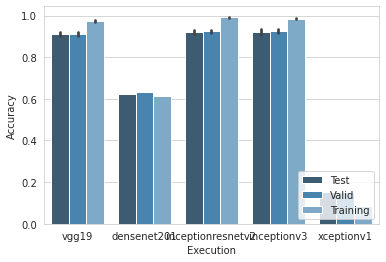

In [1]:
import os
import pandas as pd
import numpy as np
import re
import pickle
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, scale
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
from auxiliary_functions import *
from Utils import *
warnings.filterwarnings('ignore')

##############################################################
# Directories, files, parameters
##############################################################
plots_dir = "plots"
PATH = "results/"
feat_file='cloud_features.csv'

parameters_rf = {'n_estimators':list(range(100,1600,100))}
#parameters_rf = {'n_estimators':[200]}


##############################################################
# Obtaining best CNN execution (in training set)
##############################################################

summary_files = [each for each in os.listdir(PATH) if each.endswith('_summary_acc.csv')]

# Generating dataframe with all summary files. New columns with file name, model name and set name (train,valid,test)
df = pd.concat((pd.read_csv(os.path.join(PATH, f)).assign(file = f).assign(model = re.search('[0-9]_+(.+?)_summary_acc.csv', f).group(1).split("_")[0]).
                assign(set = re.search('[0-9]_+(.+?)_summary_acc.csv', f.replace("no_ceil_", "")).group(1).split("_")[1]) for f in summary_files))

# Extracting validation results to find best execution
# df_val = df[df["set"] == "valid"]

df_train = df[df["set"] == "train"]


best_exec_acc_val = df_train[df_train["macro_avg-precision"] == max(df_train["macro_avg-precision"])]
file_best_exec = best_exec_acc_val["file"][0]
file_best_exec_id = re.search('(.+?)_[a-z]+_summary_acc.csv', file_best_exec).group(1)

#file_best_exec_id = "15843976137157693_vgg19_no_ceil"
#file_best_exec = "15843976137157693_vgg19_no_ceil_valid_summary_acc.csv"
##############################################################
# General statistics CNN
##############################################################


df['execution'] = df.groupby(['model', 'set']).cumcount()
df['execution'].astype('int32')
df_melt = pd.melt(df[df["set"] == "test"], id_vars=['model',  'execution'], value_vars=['accuracy'])

#sns.set_style("darkgrid")
#ax = sns.lineplot(x="execution", y="value", data=df_melt, estimator=None, style="model",  markers=["o", "o", "o"])

#sns.set_style("darkgrid")
sns.set_style("whitegrid")
#ax = sns.lineplot(x="execution", y="value", data=df_melt, estimator=None, style="model",  markers=["o", "o", "o"])

ax2 = sns.barplot(x="execution", y="value", hue="model", data=df_melt, palette="Blues_d")
ax2.set(xlabel='Execution', ylabel='Test accuracy')
ax2.legend(loc=4)

ax2.figure.savefig("plots/1_cnn_comparison_barplot.pdf", dpi=300)


plt.clf()

df['set'] = df['set'].map({'test': "Test", 'train': "Training", 'valid':"Valid"})
#sns.set_style("darkgrid")
sns.set_style("whitegrid")
#ax = sns.lineplot(x="execution", y="value", data=df_melt, estimator=None, style="model",  markers=["o", "o", "o"])

ax3 = sns.barplot(x="model", y="accuracy", hue="set", data=df, palette="Blues_d")
ax3.set(xlabel='Execution', ylabel='Accuracy')
ax3.legend(loc=4)

ax3.figure.savefig("plots/1_cnn_comparison_set_barplot.pdf", dpi=300)


##############################################################
# Reading indices of the best CNN execution
##############################################################
# Reading indices of the best CNN execution
indices_file = file_best_exec.replace("train_summary_acc.csv", "indices.pickle")
with open(os.path.join(PATH,indices_file), 'rb') as f:
    in_train, in_valid, in_test  = pickle.load(f)

##############################################################
# Reading predictions of the best CNN execution
##############################################################
# Reading predictions of the best CNN execution
preds_file = file_best_exec.replace("train_summary_acc.csv", "preds.csv")
preds_cnn_train = pd.read_csv(os.path.join(PATH, "%s_train_preds.csv" % file_best_exec_id), index_col=0)
preds_cnn_test = pd.read_csv(os.path.join(PATH, "%s_test_preds.csv" % file_best_exec_id), index_col=0)
preds_cnn_valid = pd.read_csv(os.path.join(PATH, "%s_valid_preds.csv" % file_best_exec_id), index_col=0)


y_train = preds_cnn_train["obs"]
y_test = preds_cnn_test["obs"]
y_valid = preds_cnn_valid["obs"]


# Deleting observation column
del preds_cnn_train["obs"]
del preds_cnn_test["obs"]
del preds_cnn_valid["obs"]

test_summary_data_cnn = pd.read_csv(os.path.join(PATH, "%s_test_summary_acc.csv" % file_best_exec_id), index_col=0)
print("Best CNN model found: %s" % file_best_exec_id)
display(test_summary_data_cnn)

latex_table_summary = pd.DataFrame(test_summary_data_cnn).transpose().round(2).to_latex(os.path.join("plots", "2_cnn_metrics_table.tex"))

#with open(os.path.join("plots", "2_cnn_metrics_table.tex"),'w') as tf:
#    tf.write(latex_table_summary)
# Reading data and applying indices

data = load_data_with_indices("data/",
                in_train = in_train,
                in_valid = in_valid,
                in_test = in_test)

encoder = data["label_encoder"]
estimators_train = data['features'][0]
estimators_train.drop(["ceil.height0", "ceil.height1",
              "ceil.height2", "ceil.depth0",
              "ceil.depth1", "ceil.depth2",
              "ceil.layers"], axis=1)
estimators_test = data['features'][-1]
estimators_test.drop(["ceil.height0", "ceil.height1",
             "ceil.height2", "ceil.depth0",
             "ceil.depth1", "ceil.depth2",
             "ceil.layers"], axis=1)


img_train, ceil_train, y_train= data['train']
img_test, ceil_test, y_test= data['test']

y_train = data['label_encoder'].inverse_transform(data['train'][-1])

y_test = data['label_encoder'].inverse_transform(data['test'][-1])


preds_cnn_train_hot = encoder.transform(preds_cnn_train)
preds_cnn_valid_hot = encoder.transform(preds_cnn_valid)
preds_cnn_test_hot = encoder.transform(preds_cnn_test)

statistics_cnn = df[['accuracy', 'macro_avg-precision', 'model', 'set']].groupby(['model', 'set']).agg(['mean', 'std'])

statistics_cnn.round(4).to_latex(os.path.join("plots", "3_cnn_statistics.tex"))

display(statistics_cnn.round(4)*100)





In [2]:
cl_report_dict_best_cnn = classification_report(y_pred= preds_cnn_test, y_true= y_test, digits= 3, output_dict=True)
report_classes_exp1 = pd.DataFrame(cl_report_dict_best_cnn).transpose().round(4)

#### Generating history plots

,Execution,Model,Metric,Loss
0,0,vgg19,loss,1.957395
1,1,vgg19,loss,1.420620
2,2,vgg19,loss,1.227668
3,3,vgg19,loss,1.012031
4,4,vgg19,loss,0.911049
...,...,...,...,...
2901,49,inceptionv3,val_loss,0.558268
2902,50,inceptionv3,val_loss,0.462931
2903,51,inceptionv3,val_loss,0.544139
2904,52,inceptionv3,val_loss,0.434257


<Figure size 432x288 with 0 Axes>

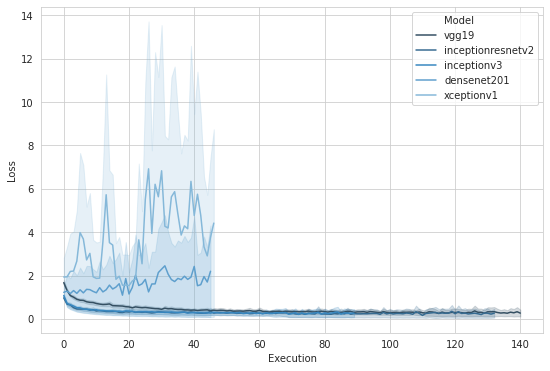

In [2]:
history_file = file_best_exec.replace("train_summary_acc.csv", "history.pickle")
with open(os.path.join(PATH,history_file), 'rb') as f:
    history  = pickle.load(f)
    
hist_df = pd.DataFrame(history) 
hist_df["Execution"] = range(len(hist_df))

hist_df_melt = pd.melt(hist_df, id_vars=['Execution'], value_vars=['loss', 'val_loss'])
hist_df_melt = hist_df_melt.rename(columns={"variable": "Metric", "value": "Loss"})

sns.set_style("whitegrid")
#ax = sns.lineplot(x="execution", y="value", data=df_melt, estimator=None, style="model",  markers=["o", "o", "o"])

ax4 = sns.lineplot(x="Execution", y="Loss", hue="Metric", data=hist_df_melt, palette="Blues_d")
#ax4.set(xlabel='Execution', ylabel='Test accuracy')
ax4.legend(loc=1)

ax4.figure.savefig("plots/best_cnn_epochs_loss.pdf", dpi=300)

all_history_files = [each for each in os.listdir(PATH) if each.endswith('history.pickle')]

history_files_dfs = []

for history_file in all_history_files:
    with open(os.path.join(PATH,history_file), 'rb') as f:
        history  = pickle.load(f)
        hist_df = pd.DataFrame(history) 
        hist_df["Execution"] = range(len(hist_df))
        hist_df["Model"] = re.search('[0-9]_+(.+?)_history.pickle', history_file).group(1).split("_")[0]
        history_files_dfs.append(hist_df)
        

dfs_histories = pd.concat((history_files_dfs))

dfs_histories_melt = pd.melt(dfs_histories, id_vars=['Execution', 'Model'], value_vars=['loss', 'val_loss'])
dfs_histories_melt = dfs_histories_melt.rename(columns={"variable": "Metric", "value": "Loss"})


display(dfs_histories_melt)

plt.clf()

plt.figure(figsize=(9,6))

sns.set_style("whitegrid")
#ax = sns.lineplot(x="execution", y="value", data=df_melt, estimator=None, style="model",  markers=["o", "o", "o"])

ax5 = sns.lineplot(x="Execution", y="Loss", hue="Model", data=dfs_histories_melt, palette="Blues_d")
#ax4.set(xlabel='Execution', ylabel='Test accuracy')
ax5.legend(loc=1)

ax5.figure.savefig("plots/cnns_epochs_loss_comparison.pdf", dpi=300)



### Summary of features

- **preds_cnn_train, preds_cnn_test, preds_cnn_valid**: predictions of the best CNN model
- **estimators_train, estimators_test, estimators_valid**: estimators to train RF classifier
- **ceil_train, ceil_test, ceil_valid**: features to combine with outputs of RF and CNN classifiers



## Experiment 2: RF on estimators classification

,Classifier,Train_accuracy,Test_accuracy,Train_macro_avg_precision,Test_macro_avg_precision,Train_macro_avg_weighted_precision,Test_macro_weighted_avg_precision
0,LogisticRegression,0.8346,0.7291,0.8313,0.6721,0.8313,0.7505
1,LinearDiscriminantAnalysis,0.7776,0.7021,0.7801,0.6371,0.7801,0.7387
2,KNeighborsClassifier,0.9420,0.7389,0.9421,0.6805,0.9421,0.7519
3,DecisionTreeClassifier,1.0000,0.8061,1.0000,0.7856,1.0000,0.8068
4,GaussianNB,0.5609,0.4789,0.5391,0.4455,0.5391,0.5900
5,SVM-linear,0.9249,0.8072,0.9240,0.7663,0.9240,0.8091
6,SVM-poly,0.8171,0.6804,0.8164,0.6429,0.8164,0.6963
7,SVM-rbf,0.8811,0.7736,0.8801,0.7429,0.8801,0.7802
8,SVM-sigmoid,0.4312,0.3868,0.4211,0.3780,0.4211,0.4866
9,RandomForestClassifier,1.0000,0.8971,1.0000,0.8817,1.0000,0.8954


Grid search Random Forest
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  9.9min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 11.2min finished


RF on training set results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.559223,0.295916,0.038775,0.000832,100,{'n_estimators': 100},0.967853,0.974714,0.975379,0.972413,0.984166,0.974905,0.005329,15
1,16.958720,0.279115,0.071542,0.003506,200,{'n_estimators': 200},0.970329,0.977364,0.976025,0.974409,0.984703,0.976566,0.004705,1
2,25.984198,0.405596,0.102896,0.005959,300,{'n_estimators': 300},0.969039,0.974818,0.977828,0.974135,0.985328,0.976230,0.005356,2
3,34.379818,0.954187,0.133940,0.003678,400,{'n_estimators': 400},0.969050,0.976049,0.976540,0.972995,0.985328,0.975992,0.005379,3
4,42.165947,0.696158,0.163364,0.003389,500,{'n_estimators': 500},0.970288,0.974072,0.977138,0.972931,0.985328,0.975951,0.005178,4
5,51.263644,1.362007,0.197652,0.007163,600,{'n_estimators': 600},0.968979,0.974142,0.976497,0.972931,0.985302,0.975570,0.005441,5
6,59.159251,0.887694,0.226888,0.005264,700,{'n_estimators': 700},0.968332,0.972239,0.977149,0.973646,0.985302,0.975334,0.005729,9
7,68.277511,1.379221,0.266257,0.016655,800,{'n_estimators': 800},0.967641,0.973535,0.976539,0.973015,0.985302,0.975206,0.005806,12
8,76.969985,2.524845,0.288962,0.006655,900,{'n_estimators': 900},0.968292,0.973535,0.976510,0.973015,0.985302,0.975331,0.005638,10
9,84.470764,1.329894,0.321008,0.005741,1000,{'n_estimators': 1000},0.968292,0.973535,0.976510,0.973646,0.984738,0.975344,0.005394,8


                precision    recall  f1-score   support

       aerosol     0.9524    1.0000    0.9756        20
   altocumulos     0.8523    0.8523    0.8523        88
   altostratos     0.9412    0.8889    0.9143        36
cieloDespejado     1.0000    0.8261    0.9048        23
  cirrocumulos     0.6364    0.6667    0.6512        21
        cirros     0.9103    0.9793    0.9435       145
  cirrostratos     0.9688    0.9118    0.9394        68
       cumulos     0.9429    0.9296    0.9362        71
estratocumulos     0.8912    0.9225    0.9066       142
      estratos     0.9204    0.9630    0.9412       108
     multinube     0.9000    0.8571    0.8780       189
  nimbostratos     0.5556    0.4167    0.4762        12

      accuracy                         0.9014       923
     macro avg     0.8726    0.8512    0.8599       923
  weighted avg     0.9012    0.9014    0.9004       923

RF over estimators. Best no. estimators RF: 200


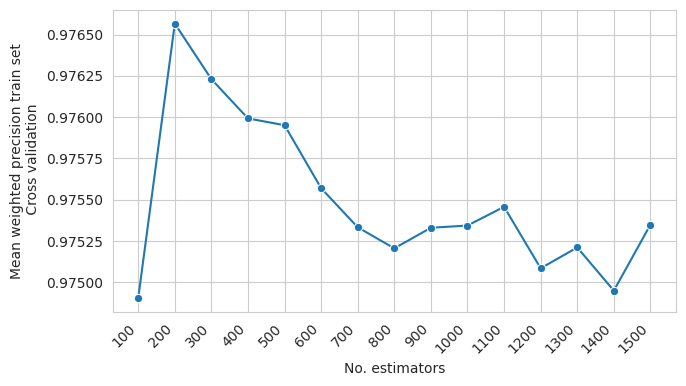

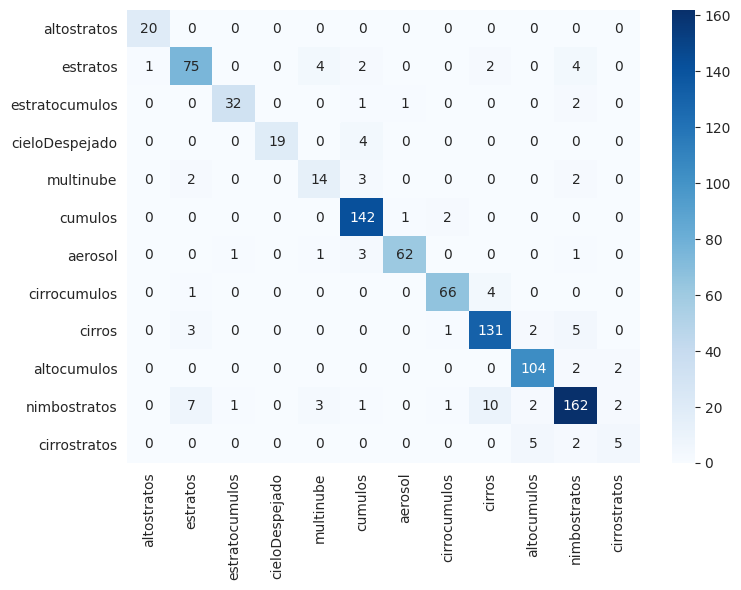

In [5]:

##############################################################
# Experiment 2: RF on estimators classification
##############################################################
experiment_name = "EXP_2_RF_estimators"

##############################################################
# Classic classifiers comparison
##############################################################
results_classifiers_rf_estimators, _, _ = train_classifiers_on_set(X_train=estimators_train, Y_train=y_train, 
                         X_test=estimators_test, Y_test=y_test, 
                         output_file_id=file_best_exec_id, experiment_name=experiment_name, 
                         output_dir=plots_dir, encoder=encoder)

##############################################################
# Training RF with different no. estimators
##############################################################
preds_estimators_test_RF_hot, preds_estimators_train_RF_hot, grid_rf_rf_estimators, grid_rf_best_params, cl_report_dict_rf_estimators, conf_matrix_rf_estimators = grid_search_rf(
    X_train=estimators_train, Y_train=y_train, X_test=estimators_test, Y_test=y_test,
               encoder=encoder, parameters_rf=parameters_rf, file_best_exec_id=file_best_exec_id,
               experiment_name=experiment_name, output_dir=plots_dir)

print("RF over estimators. Best no. estimators RF: %d" % grid_rf_best_params["n_estimators"])

report_classes_exp2 = pd.DataFrame(cl_report_dict_rf_estimators).transpose().round(4)

In [5]:
report_classes_exp2 = pd.DataFrame(cl_report_dict_rf_estimators).transpose().round(2)

In [6]:
"""
fig = plt.figure(figsize=(7.27, 4), dpi=100)
ax = sns.lineplot(x="param_n_estimators", y="mean_test_score", marker="o", data=pd.DataFrame(grid_rf_rf_estimators))
ax.set(xlabel='No. estimators', ylabel='Mean accuracy in the training set\n Cross validation')
ax.set(xticks=np.asarray(parameters_rf["n_estimators"]), xticklabels=np.asarray(parameters_rf["n_estimators"]))
#ax.set(xticks=np.asarray(parameters_rf["n_estimators"]))
ax.set_xticklabels(np.asarray(parameters_rf["n_estimators"]), rotation=45, horizontalalignment='right')#fig.savefig(os.path.join("plots/", ("{}_rf_train_results_no_estimators_{}.pdf".format(file_best_exec_id, experiment_name))), bbox_inches='tight', pad_inches=0.1)


print("RF over estimators. Best no. estimators RF: %d" % grid_rf_best_params["n_estimators"])

"""

'\nfig = plt.figure(figsize=(7.27, 4), dpi=100)\nax = sns.lineplot(x="param_n_estimators", y="mean_test_score", marker="o", data=pd.DataFrame(grid_rf_rf_estimators))\nax.set(xlabel=\'No. estimators\', ylabel=\'Mean accuracy in the training set\n Cross validation\')\nax.set(xticks=np.asarray(parameters_rf["n_estimators"]), xticklabels=np.asarray(parameters_rf["n_estimators"]))\n#ax.set(xticks=np.asarray(parameters_rf["n_estimators"]))\nax.set_xticklabels(np.asarray(parameters_rf["n_estimators"]), rotation=45, horizontalalignment=\'right\')#fig.savefig(os.path.join("plots/", ("{}_rf_train_results_no_estimators_{}.pdf".format(file_best_exec_id, experiment_name))), bbox_inches=\'tight\', pad_inches=0.1)\n\n\nprint("RF over estimators. Best no. estimators RF: %d" % grid_rf_best_params["n_estimators"])\n\n'

## Experiment 3: Average of RF over estimators + CNN predictions

                precision    recall  f1-score   support

       aerosol     1.0000    1.0000    1.0000        20
   altocumulos     0.9341    0.9659    0.9497        88
   altostratos     0.8750    0.7778    0.8235        36
cieloDespejado     0.9545    0.9130    0.9333        23
  cirrocumulos     0.8947    0.8095    0.8500        21
        cirros     0.9161    0.9793    0.9467       145
  cirrostratos     0.9552    0.9412    0.9481        68
       cumulos     0.9589    0.9859    0.9722        71
estratocumulos     0.9630    0.9155    0.9386       142
      estratos     0.9211    0.9722    0.9459       108
     multinube     0.9235    0.8942    0.9086       189
  nimbostratos     0.9167    0.9167    0.9167        12

      accuracy                         0.9339       923
     macro avg     0.9344    0.9226    0.9278       923
  weighted avg     0.9340    0.9339    0.9333       923



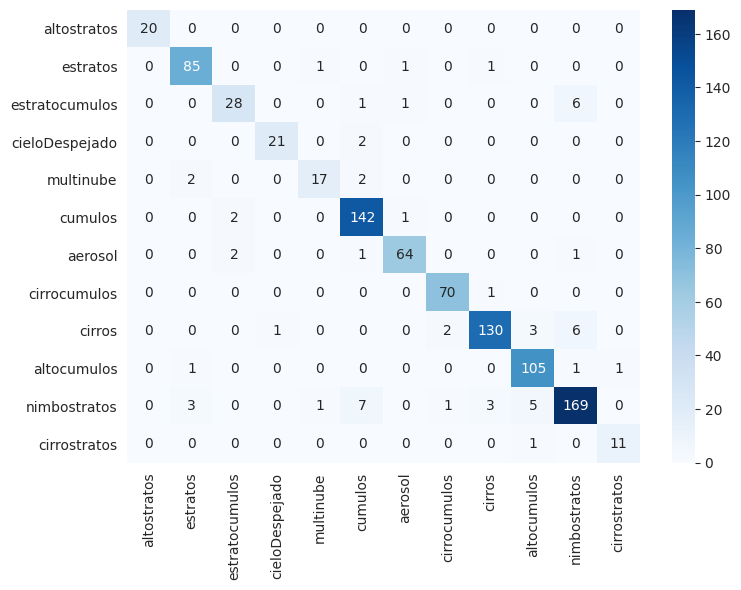

In [7]:
##############################################################
# Experiment 3: Average of RF over estimators + CNN predictions
##############################################################
experiment_name = "EXP_3_RF_estimators_CNN"

# Test set of classifiers
#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
preds_estimators_test_RF_CNN = encoder.inverse_transform((preds_estimators_test_RF_hot + preds_cnn_test_hot)/2)

print(classification_report(y_pred= preds_estimators_test_RF_CNN, y_true= y_test, digits= 4))
cl_report_dict_rf_cnn, conf_matrix_rf_cnn = generate_confusion_matrix_and_report(y_pred=preds_estimators_test_RF_CNN, y_test_dec=y_test, output_file_id=file_best_exec_id, experiment_name=experiment_name, output_dir=plots_dir)


report_classes_exp3 = pd.DataFrame(cl_report_dict_rf_cnn).transpose().round(5)

In [3]:
report_classes_exp3 = pd.DataFrame(cl_report_dict_rf_cnn).transpose().round(5)

NameError: name 'cl_report_dict_rf_cnn' is not defined

## Experiment 4: Standard classifiers on CNN predictions + RF over estimators

In [8]:
##############################################################
# Experiment 4: Standard classifiers on CNN predictions + RF over estimators
##############################################################
experiment_name = "EXP_4_standard_classifiers_CNN_RF"
print("EXPERIMENT %s" % experiment_name)


#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
#preds_estimators_test_RF = encoder.inverse_transform(preds_estimators_test_RF_hot)

x_train_cnn_rf_predictions = np.concatenate((preds_estimators_train_RF_hot, preds_cnn_train_hot), axis=1)
x_test_cnn_rf_predictions = np.concatenate((preds_estimators_test_RF_hot, preds_cnn_test_hot), axis=1)



results_classifiers_cnn_rf_estimators, best_model_name_exp4, best_model_decod_test_exp4 = train_classifiers_on_set(X_train=x_train_cnn_rf_predictions, Y_train=y_train, 
                         X_test=x_test_cnn_rf_predictions, Y_test=y_test, 
                         output_file_id=file_best_exec_id, experiment_name=experiment_name, output_dir=plots_dir,
                         encoder=encoder)


cl_report_dict_exp4 = classification_report(y_pred= best_model_decod_test_exp4, y_true= y_test, digits= 3, output_dict=True)
report_classes_exp4 = pd.DataFrame(cl_report_dict_exp4).transpose().round(4)


EXPERIMENT EXP_4_standard_classifiers_CNN_RF


,Classifier,Train_accuracy,Test_accuracy,Train_macro_avg_precision,Test_macro_avg_precision,Train_macro_avg_weighted_precision,Test_macro_weighted_avg_precision
0,LogisticRegression,0.9996,0.9404,0.9996,0.9390,0.9996,0.9403
1,LinearDiscriminantAnalysis,0.9989,0.9166,0.9989,0.9154,0.9989,0.9169
2,KNeighborsClassifier,0.9990,0.9252,0.9990,0.9302,0.9990,0.9256
3,DecisionTreeClassifier,1.0000,0.8743,1.0000,0.8969,1.0000,0.9119
4,GaussianNB,0.9995,0.8917,0.9995,0.9305,0.9995,0.9007
5,SVM-linear,0.9999,0.9317,0.9999,0.9378,0.9999,0.9320
6,SVM-poly,0.9997,0.9079,0.9997,0.9511,0.9997,0.9194
7,SVM-rbf,0.9999,0.9263,0.9999,0.9398,0.9999,0.9270
8,SVM-sigmoid,0.9995,0.9447,0.9995,0.9432,0.9995,0.9449
9,RandomForestClassifier,1.0000,0.9220,1.0000,0.9292,1.0000,0.9232


In [15]:
report_classes_exp4 = pd.DataFrame(cl_report_dict_exp4).transpose().round(4)
report_classes_exp3 = pd.DataFrame(cl_report_dict_rf_cnn).transpose().round(4)
report_classes_exp2 = pd.DataFrame(cl_report_dict_rf_estimators).transpose().round(4)
report_classes_exp1 = pd.DataFrame(cl_report_dict_best_cnn).transpose().round(4)
report_classes_exp4

,precision,recall,f1-score,support
aerosol,1.0000,1.0000,1.0000,20.0000
altocumulos,0.9348,0.9773,0.9556,88.0000
altostratos,0.8750,0.7778,0.8235,36.0000
cieloDespejado,0.9545,0.9130,0.9333,23.0000
cirrocumulos,0.9000,0.8571,0.8780,21.0000
cirros,0.9346,0.9862,0.9597,145.0000
cirrostratos,0.9846,0.9412,0.9624,68.0000
cumulos,0.9859,0.9859,0.9859,71.0000
estratocumulos,0.9779,0.9366,0.9568,142.0000
estratos,0.9292,0.9722,0.9502,108.0000


In [16]:
report_classes_exp1
report_classes_exp2
report_classes_exp3
report_classes_exp4
all_report_classes = pd.concat([report_classes_exp1.add_suffix('_exp1'), report_classes_exp2.add_suffix('_exp2') , 
           report_classes_exp3.add_suffix('_exp3') , report_classes_exp4.add_suffix('_exp4')], axis=1, sort=False).fillna(0) #.astype(int) for ints

 
all_report_classes.to_latex(os.path.join(plots_dir, "report_all_experiments.tex")) 

## Experiment 5: Standard classifiers on CNN predictions + RF over estimators + CEIL features

In [11]:
experiment_name = "EXP_5_standard_classifiers_ceil_CNN_RF"

#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
#preds_estimators_test_RF = encoder.inverse_transform(preds_estimators_test_RF_hot)

x_train_ceil_cnn_rf_predictions = np.concatenate((preds_estimators_train_RF_hot, preds_cnn_train_hot, ceil_train), axis=1)
x_test_ceil_cnn_rf_predictions = np.concatenate((preds_estimators_test_RF_hot, preds_cnn_test_hot, ceil_test), axis=1)



results_classifiers_ceil_cnn_rf_estimators, _, _ = train_classifiers_on_set(X_train=x_train_ceil_cnn_rf_predictions, Y_train=y_train, 
                         X_test=x_test_ceil_cnn_rf_predictions, Y_test=y_test, 
                         output_file_id=file_best_exec_id, experiment_name=experiment_name, 
                         output_dir=plots_dir, encoder=encoder)

,Classifier,Train_accuracy,Test_accuracy,Train_macro_avg_precision,Test_macro_avg_precision,Train_macro_avg_weighted_precision,Test_macro_weighted_avg_precision
0,LogisticRegression,0.9997,0.9426,0.9997,0.9465,0.9997,0.9425
1,LinearDiscriminantAnalysis,0.9989,0.9166,0.9989,0.9155,0.9989,0.9168
2,KNeighborsClassifier,0.9981,0.9231,0.9981,0.9284,0.9981,0.9231
3,DecisionTreeClassifier,1.0000,0.8787,1.0000,0.9093,1.0000,0.8997
4,GaussianNB,0.9995,0.8949,0.9995,0.9226,0.9995,0.8997
5,SVM-linear,0.9999,0.9328,0.9999,0.9347,0.9999,0.9328
6,SVM-poly,0.9992,0.9317,0.9992,0.9435,0.9992,0.9321
7,SVM-rbf,0.9994,0.9350,0.9994,0.9424,0.9994,0.9352
8,SVM-sigmoid,0.9871,0.9198,0.9878,0.9287,0.9878,0.9210
9,RandomForestClassifier,1.0000,0.9231,1.0000,0.9307,1.0000,0.9244


In [12]:
ceil_train.shape

(7932, 7)